# All Ears - CS 545 Final Project & Report

Mikyla Bowen and Nathan Orwick

## Introduction & methodology

Good description of the data and methodology (20 pts).


## Experiments & analyses

### Shared imports

In [1]:
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision import transforms
import torchvision

import shared_loader
import shared_models
import shared_utils
from shared_utils import device

import pandas as pd

### Run on CUDA if available

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## 1.0 Baseline Experiment: Each Person as a Class

In [3]:
data_df = pd.read_csv('EarData_df.csv')
data_df

,Path,Person_Label,Name,Gender
0,001.ALI_HD/001 (97).jpg,0,ALI_HD,0
1,001.ALI_HD/001 (200).jpg,0,ALI_HD,0
2,001.ALI_HD/001 (129).jpg,0,ALI_HD,0
3,001.ALI_HD/001 (269).jpg,0,ALI_HD,0
4,001.ALI_HD/001 (22).jpg,0,ALI_HD,0
...,...,...,...,...
28407,164.Yen_Nhi_H/164 (138).jpg,163,Yen_Nhi_H,1
28408,164.Yen_Nhi_H/164 (41).jpg,163,Yen_Nhi_H,1
28409,164.Yen_Nhi_H/164 (83).jpg,163,Yen_Nhi_H,1
28410,164.Yen_Nhi_H/164 (118).jpg,163,Yen_Nhi_H,1


### 1.1 Scratch Model

In [4]:
baseline_data = shared_loader.EarData(data_df, class_label = 1)

baseline_model = shared_models.CNNbaseline()
baseline_model.apply(shared_utils.init_cnn)
baseline_model = baseline_model.to(device)

optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

/usr/local/anaconda3/2023.03/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
baseline_model, baseline_loss_train, baseline_loss_valid, baseline_accuracy_valid = shared_utils.model_training(
    baseline_model, baseline_data, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True
)
print(f"accuracy: {baseline_accuracy_valid[-1]}")

accuracy: 0.01049440
epoch 10
accuracy: 0.06078980106916001


### 1.2 ResNet Fine Tuning

In [6]:
finetune_net = torchvision.models.resnet18(weights='IMAGENET1K_V1')
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 164)
nn.init.xavier_uniform_(finetune_net.fc.weight);

finetune_net=finetune_net.to(device)
batch_size=128
param_group=True
learning_rate = 0.001
train_iter = baseline_data.get_dataloader(train=True)
test_iter = baseline_data.get_dataloader(train=False)

loss_fn = nn.CrossEntropyLoss()

if param_group:
    params_1x = [param for name, param in finetune_net.named_parameters() 
                 if name not in ["fc.weight", "fc.bias"]]
    optimizer = torch.optim.SGD([{'params': params_1x},
                                 {'params': finetune_net.fc.parameters(),
                                'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
else:
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                weight_decay=0.001)
    


finetune_net, finetune_loss_train, finetune_loss_valid, finetune_accuracy_valid = shared_utils.model_training(
    finetune_net, baseline_data, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True, finetune = True
)
print(f"accuracy: {finetune_accuracy_valid[-1]}")


accuracy: 0.02273787
epoch 10
accuracy: 0.29442630597014924


### 1.0 Discussion

### Paired ear classification

train_positive=53069
train_negative=78506
val_positive=22206
val_negative=14567
train=106138
val=29134


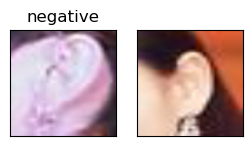

In [7]:
data = shared_loader.PairedEarData(batch_size=128)
batch = next(iter(data.get_dataloader(train=True)))
data.visualize(batch)

#### Baseline

In [8]:
model = shared_models.PairCNN()
model.apply(shared_utils.init_cnn)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

In [9]:
model, loss_train, loss_valid, accuracy_valid = shared_utils.bc_model_training(
    model, data, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True
)
print(f"accuracy: {accuracy_valid[-1]}")

accuracy: 0.52771733
epoch 10
accuracy: 0.5691665327339842


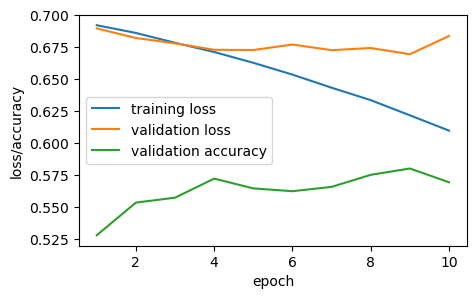

In [10]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.plot(range(1, len(loss_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

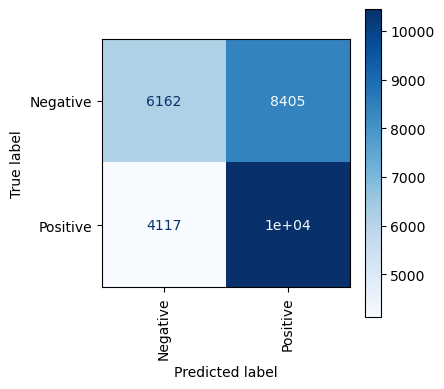

In [11]:
shared_utils.bc_confusion_matrix(data, model, device)

#### ResNet18 from scratch

In [12]:
model = shared_models.PairResnet18(pretrained=False)

model.fc.apply(shared_utils.init_cnn)
model = model.to(device)

loss_fn = nn.BCELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.001)

In [13]:
model, loss_train, loss_valid, accuracy_valid = shared_utils.bc_model_training(
    model, data, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True
)
print(f"accuracy: {accuracy_valid[-1]}")

accuracy: 0.50522875
epoch 10
accuracy: 0.6068912701387155


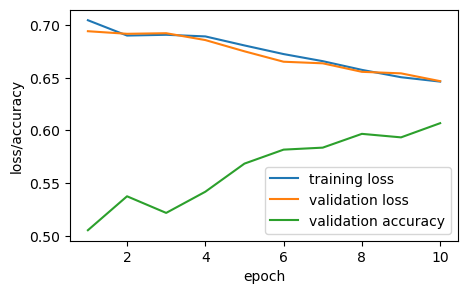

In [14]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.plot(range(1, len(loss_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

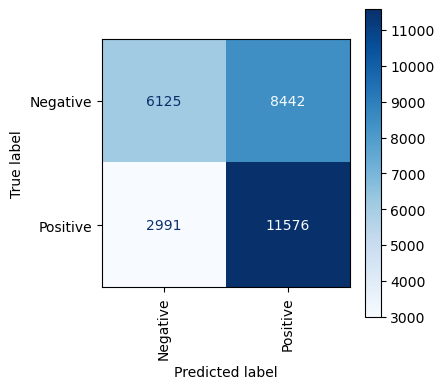

In [15]:
shared_utils.bc_confusion_matrix(data, model, device)

#### Pretrained ResNet18 fine tuning

In [16]:
model = shared_models.PairResnet18()

model.fc.apply(shared_utils.init_cnn)
model = model.to(device)

loss_fn = nn.BCELoss()

learning_rate = 0.0001
params_1x = model.resnet.parameters()
params_fc = model.fc.parameters()
optimizer = torch.optim.Adam(
    [{'params': params_1x}, {'params': params_fc, 'lr': learning_rate * 10}],
    lr=learning_rate, weight_decay=0.001
)

In [17]:
model, loss_train, loss_valid, accuracy_valid = shared_utils.bc_model_training(
    model, data, optimizer, loss_fn, epochs=3, early_stopping=False, verbose=True
)
print(f"accuracy: {accuracy_valid[-1]}")

accuracy: 0.62385598
accuracy: 0.6106237635800713


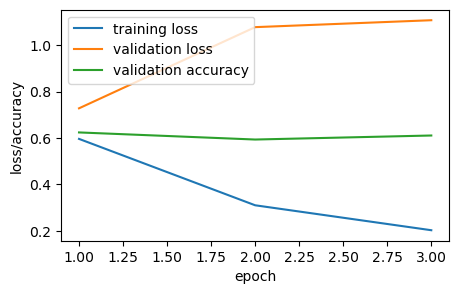

In [18]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.plot(range(1, len(loss_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

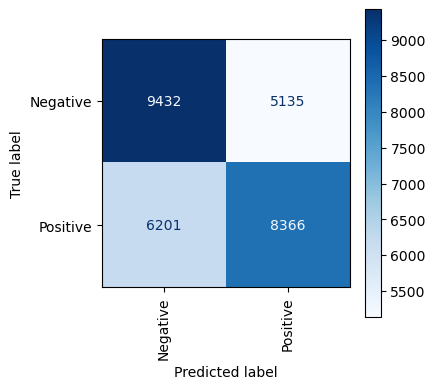

In [19]:
shared_utils.bc_confusion_matrix(data, model, device)

#### Paired ear classification discussion

Will finish in the word doc to be dropped here later

### Gender classification

In [20]:
dataset_augmentations = shared_loader.EarData(data_df, class_label = 3, augmentations = True)
dataset_clean = shared_loader.EarData(data_df, class_label = 3, augmentations = False)


In [21]:
binary_model_clean = shared_models.CNNmodified(num_classes=2)
binary_model_clean = binary_model_clean.to(device)

binary_model_clean.apply(shared_utils.init_cnn)

optimizer = torch.optim.Adam(binary_model_clean.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

/usr/local/anaconda3/2023.03/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
binary_model_clean, binary_clean_loss_train, binary_clean_loss_valid, binary_clean_accuracy_valid = shared_utils.model_training(
    binary_model_clean, dataset_clean, optimizer, loss_fn, epochs=30, early_stopping=False, verbose=True)

accuracy: 0.79326026
epoch 10
accuracy: 0.90543377
epoch 20
accuracy: 0.90788246
epoch 30


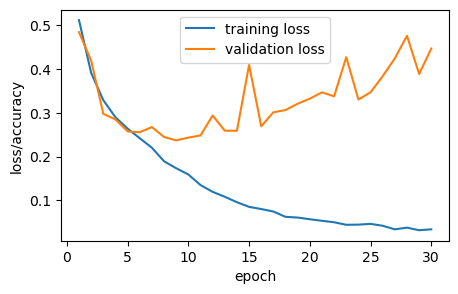

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(binary_clean_loss_train)+1), binary_clean_loss_train, label='training loss')
plt.plot(range(1, len(binary_clean_loss_valid)+1), binary_clean_loss_valid, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

In [ ]:
binary_model = shared_models.CNNmodified(num_classes=2)
binary_model = binary_model.to(device)

binary_model.apply(shared_utils.init_cnn)

optimizer = torch.optim.Adam(binary_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

binary_model, binary_loss_train, binary_loss_valid, binary_accuracy_valid = shared_utils.model_training(
    binary_model, dataset_augmentations, optimizer, loss_fn, epochs=30, early_stopping=False, verbose=True)

accuracy: 0.75139925
epoch 10
accuracy: 0.87363961


In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(binary_loss_train)+1), binary_loss_train, label='training loss')
plt.plot(range(1, len(binary_loss_valid)+1), binary_loss_valid, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

In [ ]:
finetune_net = torchvision.models.resnet18(weights='IMAGENET1K_V1')
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

finetune_net=finetune_net.to(device)
batch_size=128
param_group=True
learning_rate = 0.001
train_iter = dataset_augmentations.get_dataloader(train=True)
test_iter = dataset_augmentations.get_dataloader(train=False)

loss_fn = nn.CrossEntropyLoss()

if param_group:
    params_1x = [param for name, param in finetune_net.named_parameters() 
                 if name not in ["fc.weight", "fc.bias"]]
    optimizer = torch.optim.SGD([{'params': params_1x},
                                 {'params': finetune_net.fc.parameters(),
                                'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
else:
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                weight_decay=0.001)
    


finetune_net, finetune_loss_train, finetune_loss_valid, finetune_accuracy_valid = shared_utils.model_training(
    finetune_net, dataset_augmentations, optimizer, loss_fn, epochs=10, early_stopping=False, verbose=True, finetune = True
)
print(f"accuracy: {finetune_accuracy_valid[-1]}")


In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(range(1, len(finetune_loss_train)+1), finetune_loss_train, label='training loss')
plt.plot(range(1, len(finetune_loss_valid)+1), finetune_loss_valid, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

In [ ]:
shared_utils.confusion_matrix(dataset_augmentations, finetune_net, device)

In [ ]:
shared_utils.confusion_matrix(dataset_augmentations, binary_model, device)

In [ ]:
shared_utils.confusion_matrix(dataset_augmentations, binary_model_clean, device)

## Team member contribution

At the end of the notebook, describe team member contributions.

We could probably just make the word doc table a markdown table, maybe this will work: https://tableconvert.com/excel-to-markdown

| Task    | Contribution |Outcome |
| :-------- | :------- |:------- |
| Project Proposal Submission  | MB & NO    | Complete   |
| Data Loader | MB: Baseline/Gendered, <br> NO: Paired    |Complete   |
| Augmentations | MB   |Complete   |
| Paired Ear Recogniztion    | NO   |Complete   |
| Gender Classification | MB|Complete   |
| Analysis | MB & NO|Complete   |
| Documentation | MB & NO|Complete   |